In [83]:
from __future__ import division

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches as patches

%matplotlib inline

#### data will be a collection of random colours, so first we’ll artificially create a dataset of 100. Each colour is a 3D vector representing R, G and B values

In [108]:
# 8 colours as initial test set
raw_data = np.array([[1, 0, 0], [0, 1, 0],
                     [0, 0.5, 0.25], [0, 0, 1],
                     [0, 0, 0.5], [1, 1, 0.2],
                     [1, 0.4, 0.25], [1, 0, 1]]).T * 255
# or use random colours

#raw_data = np.random.randint(0, 255, (3, 100))

#That’s simply 100 rows of 3D vectors all between the values of 0 and 255.
raw_data

array([[255.  ,   0.  ,   0.  ,   0.  ,   0.  , 255.  , 255.  , 255.  ],
       [  0.  , 255.  , 127.5 ,   0.  ,   0.  , 255.  , 102.  ,   0.  ],
       [  0.  ,   0.  ,  63.75, 255.  , 127.5 ,  51.  ,  63.75, 255.  ]])

### Objective

Just to be clear, here’s what we’re trying to do. We want to take our 3D colour vectors and map them onto a 2D surface in such a way that similar colours will end up in the same area of the 2D surface.

### SOM Size

One important aspect of the SOM is that each of the 2D points on the grid actually represent a multi-dimensional weight vector. 

Each point on the SOM has a weight vector associated with it that is the same number of dimensions as our input data, in this case 3 to match the 3 dimensions of our colours. 
We’ll see why this is important when we go through the implementation.

### Learning Parameters

 The learning rate decides by how much we apply changes to our SOM at each iteration.
 
In practice it is best to start with a larger learning rate and reduce it slowly over time. This is so that the SOM can start by making big changes but then settle into a solution after a while.

### Implementation

For the rest of this post I will use 3D to refer to the dimensionality of the input data (which in reality could be any number of dimensions) and 2D as the dimensionality of the SOM (which we decide and could also be any number).

### Setup

To setup the SOM we need to start with the following:

Decide on and initialise the SOM parameters (as above)

Setup the grid by creating a 5×5 array of random 3D weight vectors

In [109]:
network_dimensions = np.array([5, 5])
n_iterations = 10000
init_learning_rate = 0.01

In [110]:
# establish variables based on data
m = raw_data.shape[0]
n = raw_data.shape[1]

# initial neighbourhood radius
init_radius = max(network_dimensions[0], network_dimensions[1]) / 2

# setup random weights between 0 and 1
# weight matrix needs to be one m-dimensional vector for each neuron in the SOM
net = np.random.random((network_dimensions[0], network_dimensions[1], m))

# radius decay parameter
time_constant = n_iterations / np.log(init_radius)

In [118]:
net

array([[[9.99999326e-01, 1.45545065e-02, 9.08599930e-03],
        [9.99999987e-01, 1.92468517e-01, 1.20029969e-01],
        [9.99110674e-01, 4.08344135e-01, 2.48821616e-01],
        [4.77130873e-01, 7.15960930e-01, 1.19102699e-01],
        [2.78532303e-04, 9.98951359e-01, 5.98140515e-04]],

       [[9.99999143e-01, 3.59814030e-02, 2.26888584e-02],
        [9.99999549e-01, 4.67170744e-01, 1.61789387e-01],
        [9.99976537e-01, 7.03086916e-01, 2.24737903e-01],
        [4.51636909e-01, 7.66213328e-01, 1.65906446e-01],
        [6.27196534e-05, 7.51678167e-01, 1.24173633e-01]],

       [[9.99989255e-01, 2.90761529e-02, 9.44074608e-01],
        [9.99994960e-01, 8.96064041e-01, 2.61464934e-01],
        [9.98648219e-01, 9.79890051e-01, 2.02125050e-01],
        [4.96129834e-01, 7.48069637e-01, 2.25192856e-01],
        [2.55666964e-06, 5.00037580e-01, 2.49996606e-01]],

       [[9.99624159e-01, 3.68708266e-04, 9.99244802e-01],
        [9.34355942e-01, 7.07140928e-02, 9.43375126e-01],
        

### Normalisation

First of all, SOMs train faster (and “better”) if all our values are between 0 and 1. 

This is often true with machine learning problems, and it’s to avoid one of our dimensions “dominating” the others in the learning process. 

For example, if one of our variable was salary (in the thousands) and another was height (in metres, so rarely over 2.0) then salary will get a higher importance simply because it has much higher values. 

Normalising to the unit interval will remove this effect.

In [111]:
normalise_data = True

# if True, assume all data is on common scale
# if False, normalise to [0 1] range along each column
normalise_by_column = False

# we want to keep a copy of the raw data for later
data = raw_data

# check if data needs to be normalised
if normalise_data:
    if normalise_by_column:
        # normalise along each column
        col_maxes = raw_data.max(axis=0)
        data = raw_data / col_maxes[np.newaxis, :]
    else:
        # normalise entire dataset
        data = raw_data / data.max()

1. Select a Random Input Vector

In [112]:
# select a training example at random
t = data[:, np.random.randint(0, n)].reshape(np.array([m, 1]))
t

array([[1.],
       [0.],
       [1.]])

2. Find the Best Matching Unit

In [113]:
# find its Best Matching Unit
bmu, bmu_idx = find_bmu(t, net, m)

For that to work we need a function to find the BMU. 

It need to iterate through each neuron in the SOM, measure its Euclidean distance to our input vector and return the one that’s closest. 

Note the implementation trick of not actually measuring Euclidean distance, but the squared Euclidean distance, thereby avoiding an expensive square root computation.

In [114]:
def find_bmu(t, net, m):
    """
        Find the best matching unit for a given vector, t, in the SOM
        Returns: a (bmu, bmu_idx) tuple where bmu is the high-dimensional BMU
                 and bmu_idx is the index of this vector in the SOM
    """
    bmu_idx = np.array([0, 0])
    # set the initial minimum distance to a huge number

    min_dist = np.iinfo(np.int).max
    # calculate the high-dimensional distance between each neuron and the input

    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)

            # don't bother with actual Euclidean distance, to avoid expensive sqrt operation
            sq_dist = np.sum((w - t) ** 2)

            if sq_dist < min_dist:
                min_dist = sq_dist
                bmu_idx = np.array([x, y])

    # get vector corresponding to bmu_idx
    bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(m, 1)
    # return the (bmu, bmu_idx) tuple
    return (bmu, bmu_idx)

3. Update the SOM Learning Parameters

As described above, we want to decay the learning rate over time to let the SOM “settle” on a solution.

What we also decay is the neighbourhood radius, which defines how far we search for 2D neighbours when updating vectors in the SOM. 

We want to gradually reduce this over time, like the learning rate. We’ll see this in a bit more detail in step 4.

In [115]:
def decay_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

def decay_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

def calculate_influence(distance, radius):
    return np.exp(-distance / (2* (radius**2)))

### SOM Learning

In [116]:
for i in range(n_iterations):
    
    # select a training example at random
    t = data[:, np.random.randint(0, n)].reshape(np.array([m, 1]))
    
    # find its Best Matching Unit
    bmu, bmu_idx = find_bmu(t, net, m)
    
    # decay the SOM parameters
    r = decay_radius(init_radius, i, time_constant)
    l = decay_learning_rate(init_learning_rate, i, n_iterations)
    #print('Iteration %d, radius %d, learning rate %d' %(i, r, l))
    
    
    # now we know the BMU, update its weight vector to move closer to input
    # and move its neighbours in 2-D space closer
    # by a factor proportional to their 2-D distance from the BMU
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
    
            # get the 2-D distance (again, not the actual Euclidean distance)
            w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)

            # if the distance is within the current neighbourhood radius
            if w_dist <= r**2:
                # calculate the degree of influence (based on the 2-D distance)
                influence = calculate_influence(w_dist, r)

                # now update the neuron's weight using the formula:
                # new w = old w + (learning rate * influence * delta)
                # where delta = input vector (t) - old w
                new_w = w + (l * influence * (t - w))
                # commit the new weight
                net[x, y, :] = new_w.reshape(1, 3)


### Plot the Colour Map

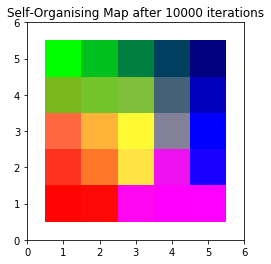

In [117]:
fig = plt.figure()
# setup axes
ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim((0, net.shape[0]+1))
ax.set_ylim((0, net.shape[1]+1))
ax.set_title('Self-Organising Map after %d iterations' % n_iterations)

# plot the rectangles
for x in range(1, net.shape[0] + 1):
    for y in range(1, net.shape[1] + 1):
        ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                     facecolor=net[x-1,y-1,:],
                     edgecolor='none'))
plt.show()